# SNR (optimal) generation and comparison 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from gwsnr import GWSNR

## Initialization

* run the following, if you want to see the documentation and the input parameters

In [5]:
# GWSNR?

* class initialization with default parameters
* IMPORTANT: set the npool parameter to the number of cores you want to use for the parallel processing
* parallel processing is use in the interpolator generation and in the SNR generation with inner-product method.

In [9]:
# gwsnr = GWSNR(gwsnr_verbose=False) # if you don't want to see the print statements
gwsnr = GWSNR()

psds not given. Choosing bilby's default psds
npool:  4
snr type:  interpolation
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
min(ratio):  0.1
max(ratio):  1.0
mtot resolution:  500
ratio resolution:  50
interpolator directory:  ./interpolator_pickle
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/halfSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/halfSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/halfSNR_dict_1.pickle


## calculate the SNR for given BBH (binary-black-hole) masses

In [10]:
mass_1 = np.array([5, 10.,50.,100.])
ratio = np.array([1, 0.8,0.5,0.2])
gwsnr.snr(mass_1=mass_1, mass_2=mass_1*ratio)

{'L1': array([ 74.07237228, 115.97500235, 310.36065119, 265.99021368]),
 'H1': array([ 47.11239983,  73.76381386, 197.39930883, 169.17829027]),
 'V1': array([22.22306148, 34.4041247 , 93.34870658, 78.61438369]),
 'optimal_snr_net': array([ 90.55472939, 141.68607977, 379.47885574, 324.88814843])}

## Testing speed and accurarcy between the interpolation method and inner product method.

* set up the BBH parameters
* simulate 1000 events

In [9]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20. to get non zero SNR
nsamples = 1000
chirp_mass = np.linspace(5,80,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

* below calculation is with inner product method
* this is similar to how snr is calculated in the `bilby` package

In [12]:
# error might occur for mchirp>95., if f_min=20. 
start_time = datetime.now()
bilby_snr = gwsnr.compute_bilby_snr(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
                            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

100%|████████████████████████████████████████████████████████████| 744/744 [00:01<00:00, 441.31it/s]

Duration: 0:00:01.726779


In [14]:
start_time = datetime.now()
interp_snr = gwsnr.snr(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.018197


* interpolation method is much faster than inner product method
* **Note:** interpolation method is only for the spinless compact binary coalescence (CBC) frequency domain waveform models.

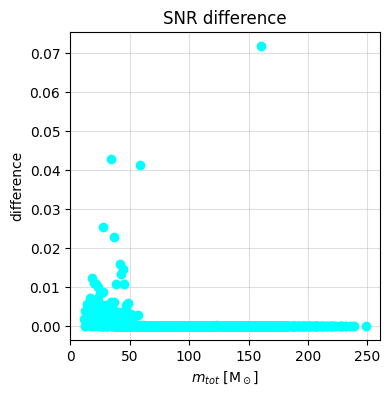

In [18]:
plt.figure(figsize=(4,4))
plt.plot(total_mass, abs(interp_snr['optimal_snr_net']-bilby_snr['optimal_snr_net']), 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"difference")
plt.title(r"SNR difference")
plt.grid(alpha=0.4)
plt.show()

## pdet (probaility of detection) calculation

In [27]:
mass_1 = np.array([2,50.,100.,])
ratio = 1.
dl = 500
snr_dict = gwsnr.snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl)
# with snr threshold equal to 8
pdet_dict = gwsnr.pdet(snr_dict)

In [28]:
print('snr: ', snr_dict["optimal_snr_net"])
print('pdet: ', pdet_dict["pdet_net"])

snr:  [  8.78159001 105.15382713   0.        ]
pdet:  [7.82772219e-01 1.00000000e+00 6.66133815e-16]


## Changing the input parameters 

What will change?
* Detectors: CE, ET.
* Minimum frequency: 10 Hz
* Maximum total mass: 500. Note that if this mass is above the allowed total mass for the given minimum frequency, i.e. the last stable orbit (LSO) frequency below the minimum frequency, then the maximum mass will be set to the maximum mass for the given minimum frequency.
* Waveform model: IMRPhenomXPHM

In [11]:
# if snr_type = 'inner_product', interpolator will not be created
from gwsnr import GWSNR
gwsnr = GWSNR(
    npool = int(4), 
    mtot_min=2.,
    mtot_max=440.,  # highest total mass possible at 10Hz
    minimum_frequency = 10.,
    snr_type = 'inner_product', 
    #psds = {'CE':'CE_psd.txt', 'ET':'ET_B_psd.txt'}, # if you want to use your own psd
    ifos = ['CE', 'ET'],  # this will considet bilby's default psd of CE and ET
)

npool:  4
snr type:  inner_product
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  10.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=10.0): 369.97199706893525


In [12]:
mass_1 = np.array([5, 10.,50.,100.])
ratio = np.array([1, 0.8,0.5,0.2])
gwsnr.snr(mass_1=mass_1, mass_2=mass_1*ratio)

solving SNR with inner product


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.96it/s]


{'CE': array([2148.90304551, 3418.3544206 , 9539.03962624, 9480.46037205]),
 'ET1': array([149.37771668, 236.23429377, 662.6230723 , 639.92876964]),
 'ET2': array([ 426.53991017,  674.55412147, 1892.0839869 , 1827.28164531]),
 'ET3': array([ 474.63277116,  750.61086744, 2105.4186128 , 2033.30973335]),
 'optimal_snr_net': array([2246.622034  , 3572.02932848, 9972.21718955, 9887.46400141])}